(hbc_template)=
# Heartbeat Counting task - Summary results

Author: Nicolas Legrand <nicolas.legrand@cas.au.dk>

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install systole, metadpy

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np
import pandas as pd
import seaborn as sns
from systole.detection import ppg_peaks
from systole.plots import plot_raw, plot_subspaces

sns.set_context('paper')
%matplotlib inline

**Import data**

In [3]:
# Define the result and report folders - This should be adapted to you own settings
resultPath = Path(Path.cwd(), "data", "HBC")
reportPath = Path(Path.cwd(), "reports")

In [4]:
# ensure that the paths are pathlib instance in case they are passed through cardioception.reports.report
resultPath = Path(resultPath)
reportPath = Path(reportPath)

In [5]:
# Search files ending with "final.txt" - This is the main data frame that is saved at the end of the task
results_df = [file for file in Path(resultPath).glob('*final.txt')]

In [6]:
# Load dataframe
df = pd.read_csv(results_df[0])
df

nTrial  Reported Condition  Duration  Confidence  ConfidenceRT
0       0        36     Count        40           4         5.146
1       1        27     Count        30           5         9.909
2       2        29     Count        35           4         4.279
3       3        39     Count        45           5         3.278
4       4        47     Count        50           5         4.007
5       5        23     Count        25           5         2.635

In [7]:
# Load raw PPG signal - PPG is saved as .npy files, one for each trial
ppg = {}
for i in range(6):
    ppg[str(i)] = np.load(
        [file for file in resultPath.glob(f'*_{i}.npy')][0]
        )

# Heartbeats and artefacts detection

```{note}
This section reports the raw PPG signal together with the peaks detected. The instantaneous heart rate frequency (R-R intervals) is derived and represented below each PPG time series. Artefacts in the RR time series are detected using the method described in {cite:p}`2019:lipponen`. The shaded areas represent the pre-recording and post-recording period. Heartbeats detected inside these intervals are automatically removed.
```

## Loop across trials

Analyzing trial number 1


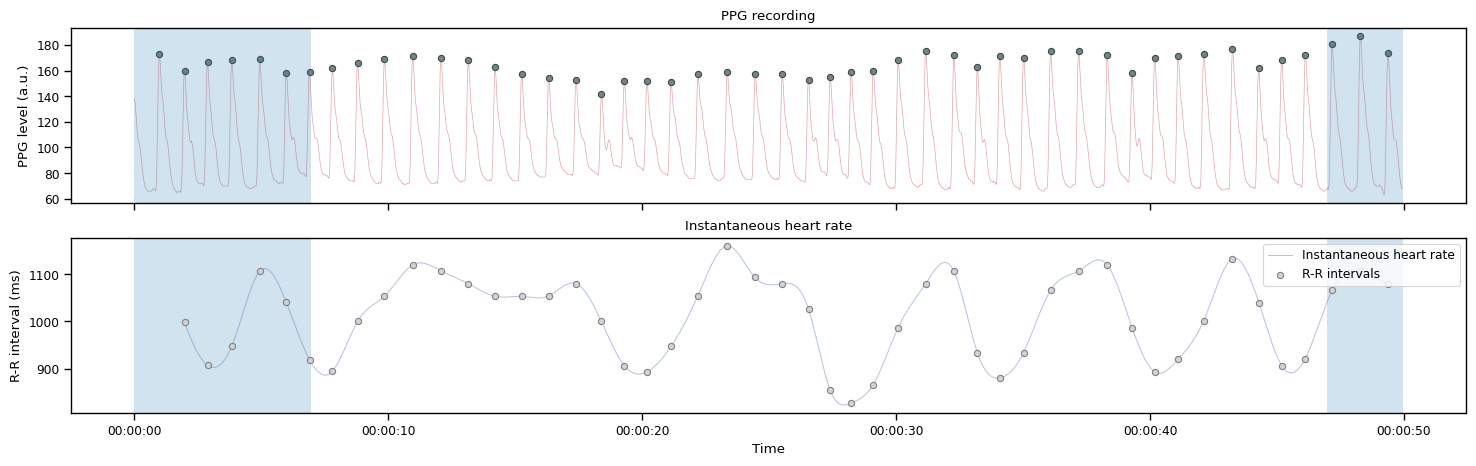

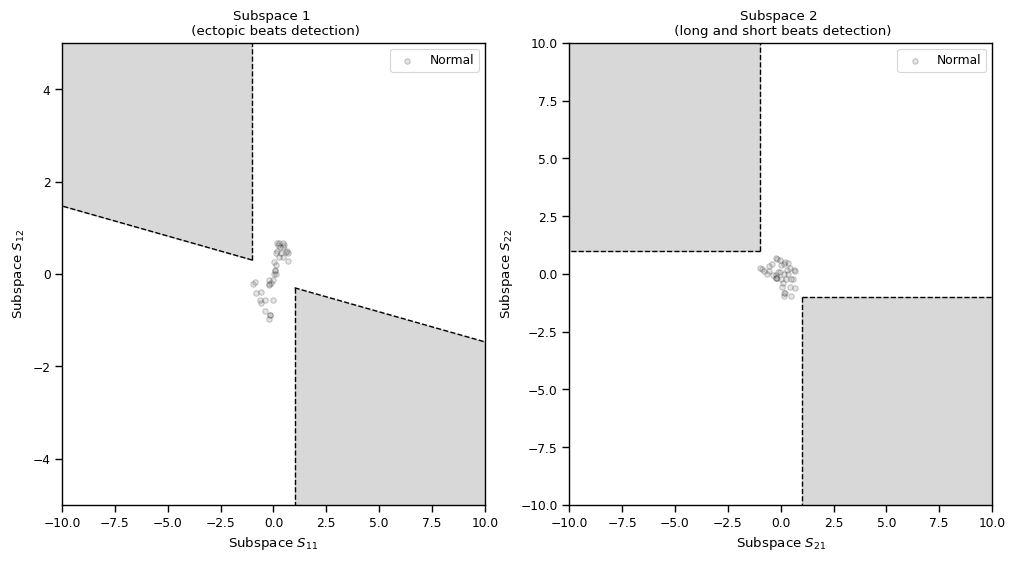

Reported: 36 beats ; Detected : 40 beats
Analyzing trial number 2


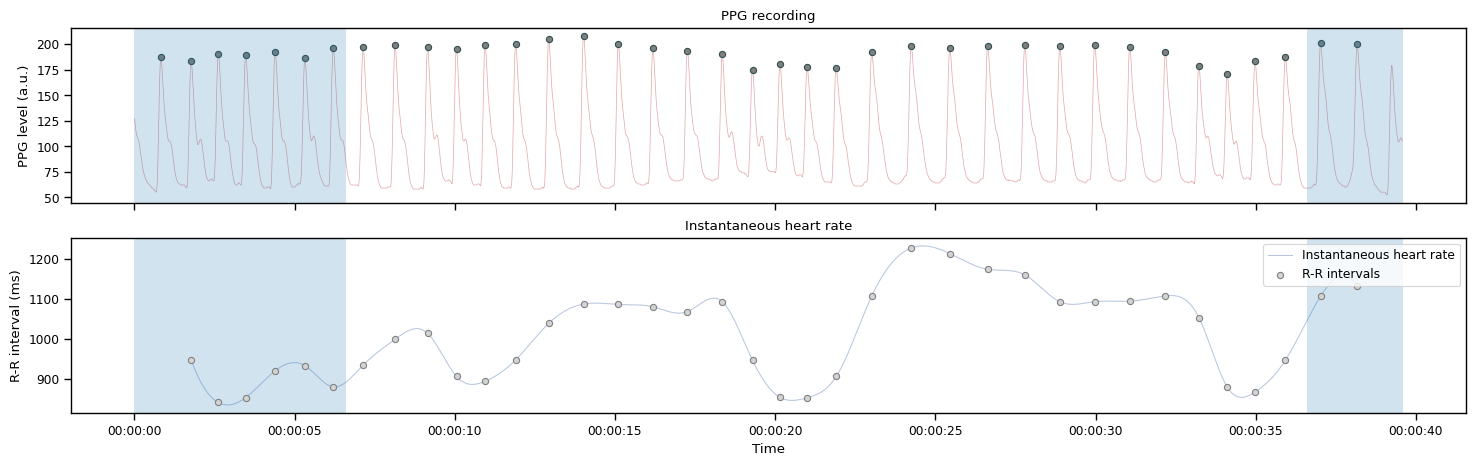

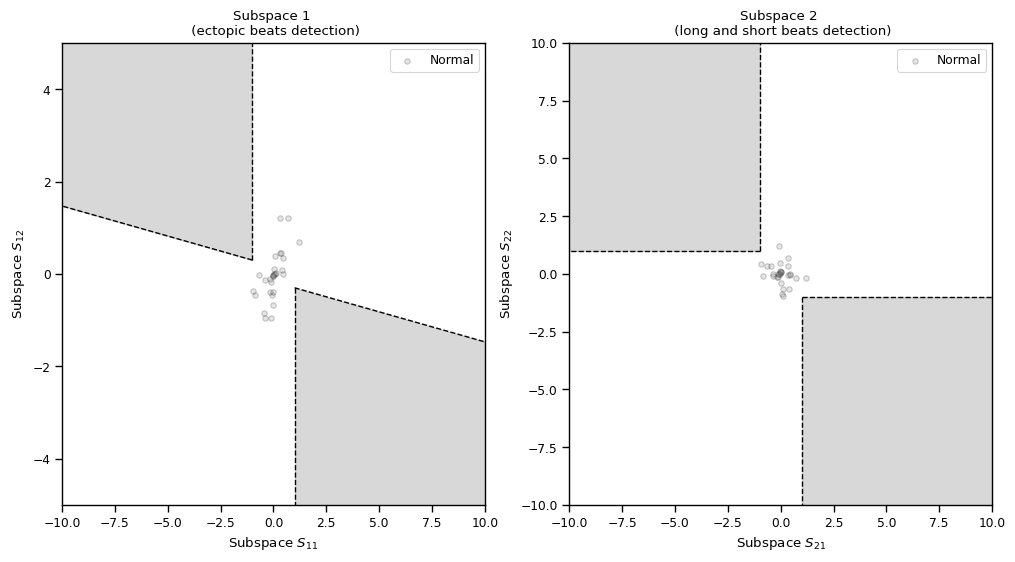

Reported: 27 beats ; Detected : 30 beats
Analyzing trial number 3


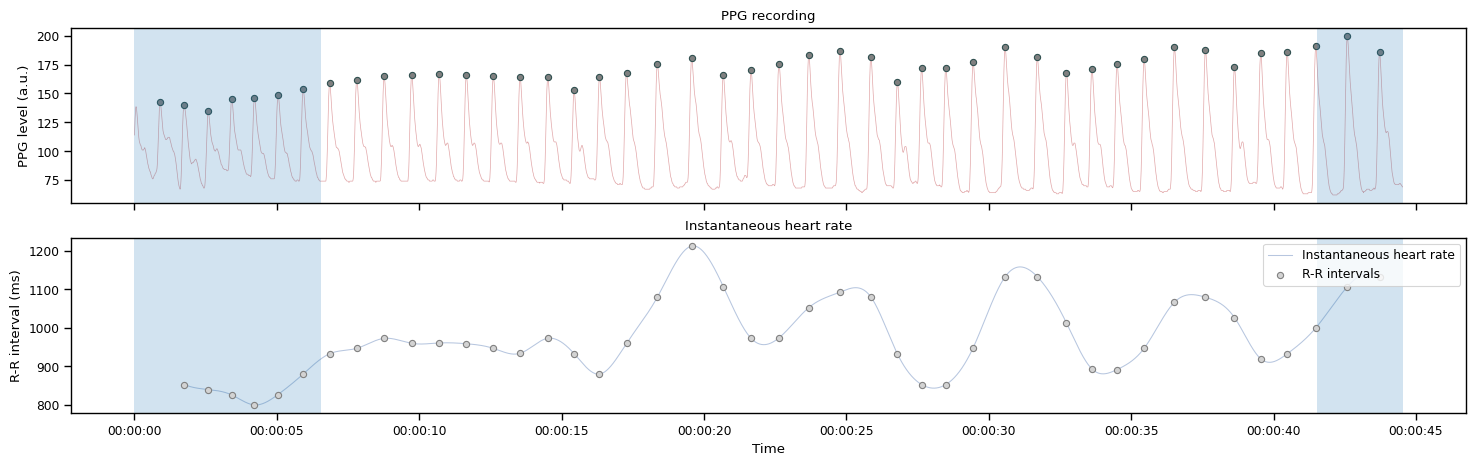

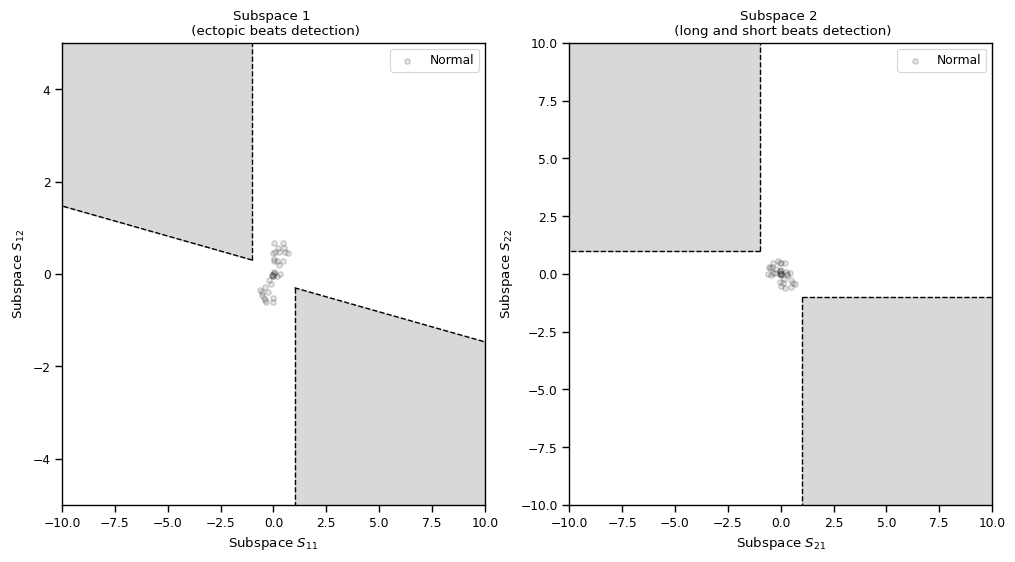

Reported: 29 beats ; Detected : 36 beats
Analyzing trial number 4


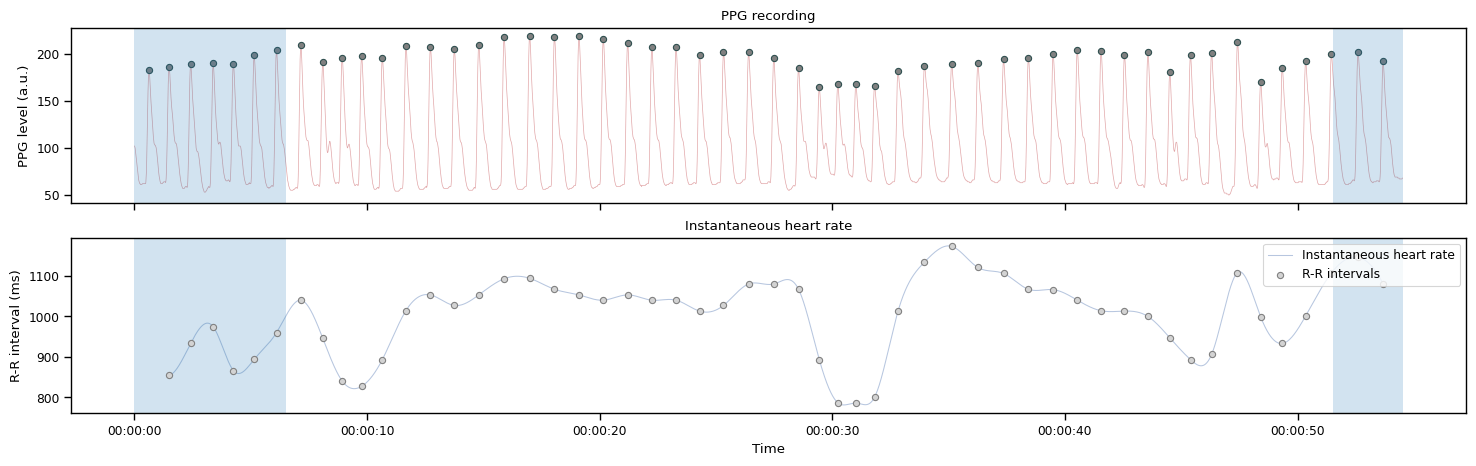

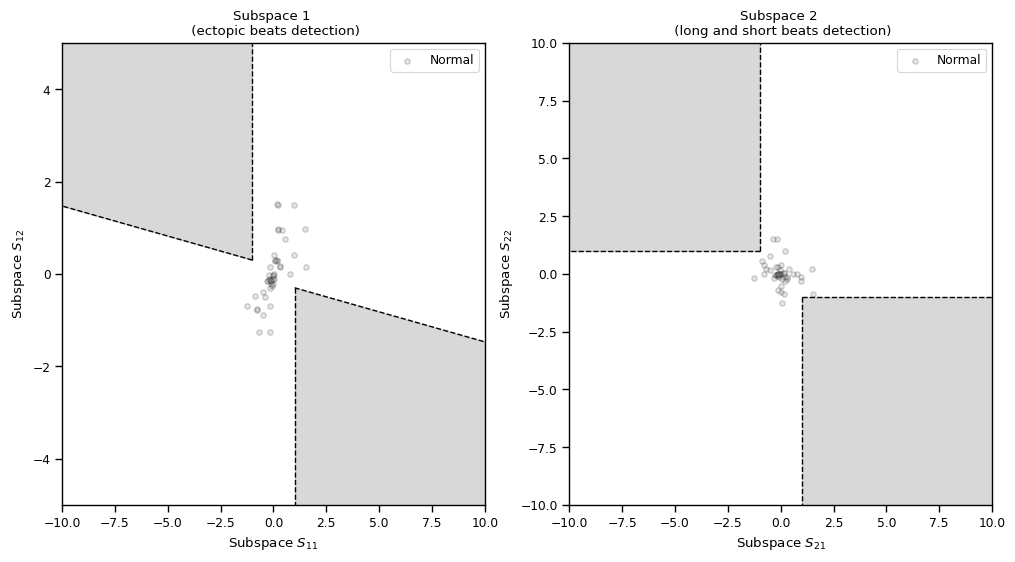

Reported: 39 beats ; Detected : 46 beats
Analyzing trial number 5


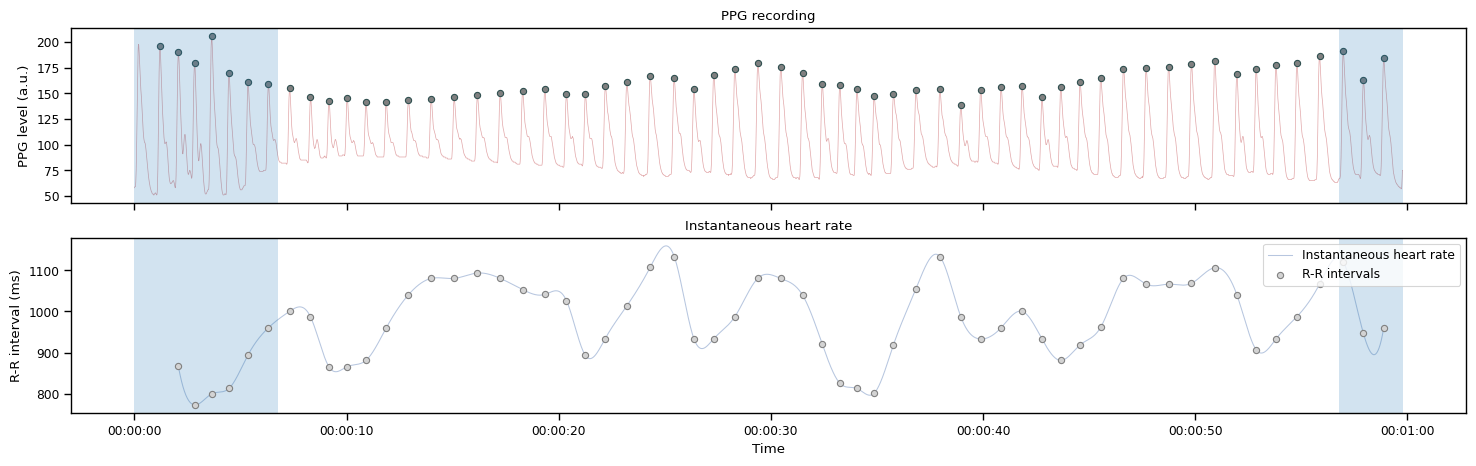

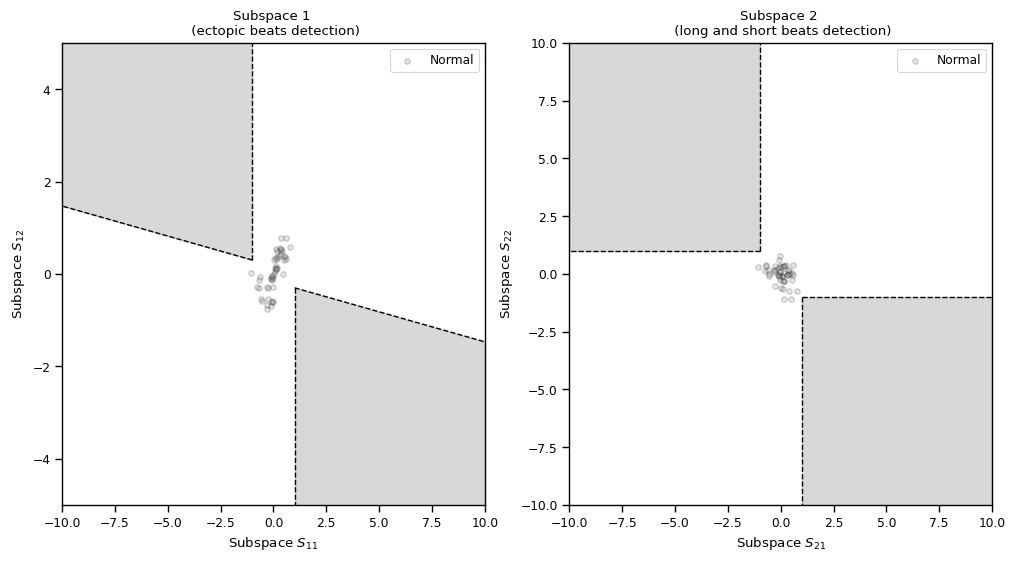

Reported: 47 beats ; Detected : 51 beats
Analyzing trial number 6


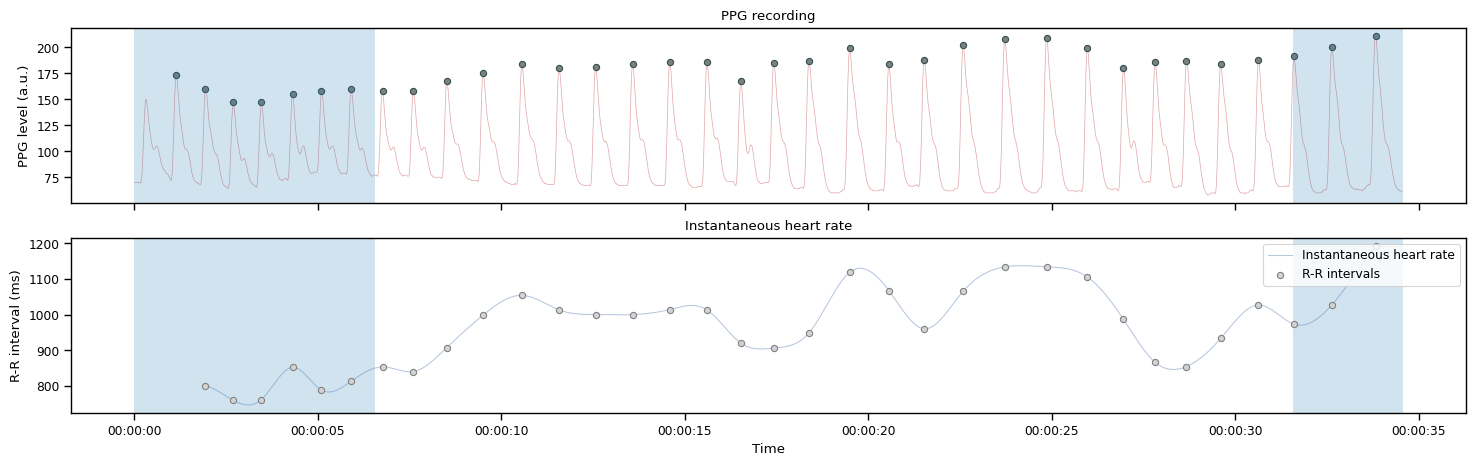

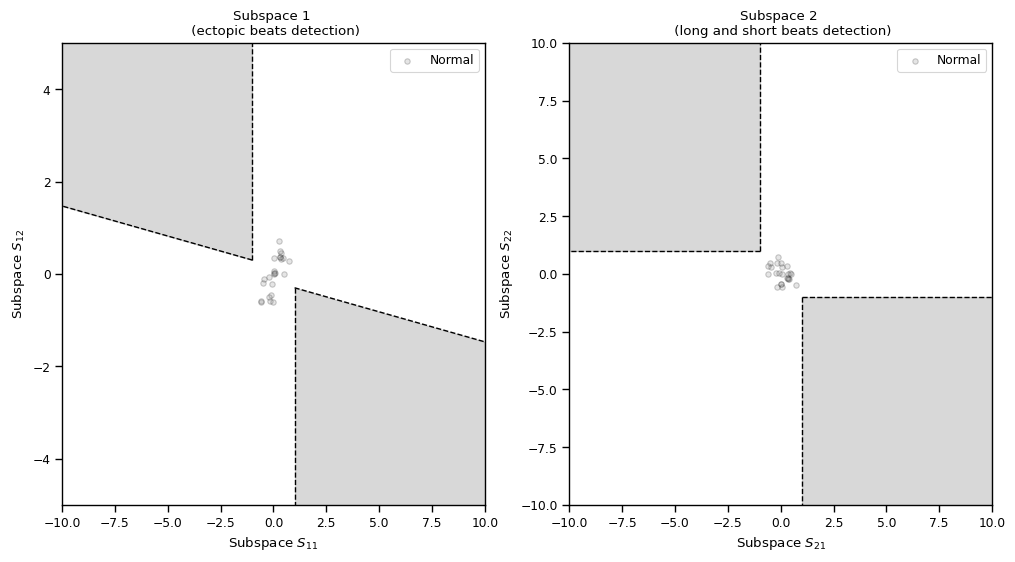

Reported: 23 beats ; Detected : 25 beats


In [8]:
counts = []
for nTrial in range(6):

    print(f'Analyzing trial number {nTrial+1}')

    signal, peaks = ppg_peaks(ppg[str(nTrial)][0], clean_extra=True, sfreq=75)
    axs = plot_raw(
        signal=signal, sfreq=1000, figsize=(18, 5), clean_extra=True,
        show_heart_rate=True
        );

    # Show the windows of interest
    # We need to convert sample vector into Matplotlib internal representation
    # so we can index it easily
    x_vec = date2num(
        pd.to_datetime(
            np.arange(0, len(signal)), unit="ms", origin="unix"
            )
        )
    l = len(signal)/1000
    for i in range(2):
        # Pre-trial time
        axs[i].axvspan(
            x_vec[0], x_vec[- (3+df.Duration.iloc[nTrial]) * 1000]
            , alpha=.2
            )
        # Post trial time
        axs[i].axvspan(
            x_vec[- 3 * 1000], 
            x_vec[- 1], 
            alpha=.2
            )
    plt.show()

    # Detected heartbeat in the time window of interest
    peaks = peaks[int(l - (3+df.Duration.iloc[nTrial]))*1000:int((l-3)*1000)]

    rr = np.diff(np.where(peaks)[0])

    _, axs = plt.subplots(ncols=2, figsize=(12, 6))
    plot_subspaces(rr=rr, ax=axs);
    plt.show()

    trial_counts = np.sum(peaks)
    print(f'Reported: {df.Reported.loc[nTrial]} beats ; Detected : {trial_counts} beats')
    counts.append(trial_counts)

## Save reults

In [9]:
# Add heartbeat counts and compute accuracy score
df['Counts'] = counts
df['Score'] = 1 - ((df.Counts - df.Reported).abs() / ((df.Counts + df.Reported)/2))

In [10]:
df

nTrial  Reported Condition  Duration  Confidence  ConfidenceRT  Counts  \
0       0        36     Count        40           4         5.146      40   
1       1        27     Count        30           5         9.909      30   
2       2        29     Count        35           4         4.279      36   
3       3        39     Count        45           5         3.278      46   
4       4        47     Count        50           5         4.007      51   
5       5        23     Count        25           5         2.635      25   

      Score  
0  0.894737  
1  0.894737  
2  0.784615  
3  0.835294  
4  0.918367  
5  0.916667

In [11]:
# Uncomment this to save the final result
#df.to_csv(Path(resultPath, 'processed.txt'))